# Capstone

The following notebook was created to help us understand what it takes, lyrically, to be in the Billboard Top 100 Charts. The data explored is largely from the years between 1999-2019, however there is some additional data that dates back to 1959. 

Throughout the notebook, we will be extensively cleaning our data and performing three separate models. The models being ran throughout the notebook are Random Forests, XGB and SVM. Additionally there will be further data exploration on how genre can play an intricate role when it comes to being involved in the Billboard's top 100 chart. 

The following variable was created as to not run cell 7. Cell 7 is where I scraped for both a genius API and a spotify API to get lyrics as well as certain spotify features. If you'd like to run cell 7 to see how it works, please feel free to change False to True.

In [1]:
scrape = False
api_file = '/Users/jamesbrochhausen/.secret/Spotify.json'
# 

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, recall_score
from xgboost import XGBRFClassifier,XGBClassifier
import shap
from imblearn.over_sampling import SMOTE
shap.initjs()
import warnings
from collections import Counter
from nltk import FreqDist
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported fr

# Data Cleaning

## Loading in our first data set

The below data set is going to be used control variable for songs that did not exist in our Billboard top 100 list we will be working with later.

In [3]:
## Loading in data
df_rando = pd.read_csv('Spotify-2000.csv', index_col=[0])

In [4]:
df_rando.head()

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
Index,,,,,,,,,,,,,,
1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


### Spotify and Genius API
Next is to scrape additional data for our above data set as we need lyrics. We'll do this by leveraging the Genius API. I was planning on leveraging the Spotify API call to gather additional information later on in regards other features such as BPM, Valence, Tempo etc. However given timing constraints I was not able to further explore how these played a roll in our goal.

In [5]:
import os

In [6]:
# pip install lyricsgenius
# pip install spotipy

In [7]:
if scrape:
    import json

    with open(api_file) as file:
        login = json.loads(file.read())

    login.keys()

    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials

    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=login['client_id'],
                                                               client_secret=login['client_secret']))

    df_rando['Lyrics']=''
    df_rando.head()

    import lyricsgenius
    genius = lyricsgenius.Genius(login['genius_secret'])

    def get_lyrics(x):
        title = x['Title']
        artist = x['Artist']

        song = genius.search_song(title, artist)
    #     print(song.lyrics)
        try: 
            return song.lyrics
        except:
            return 'Not Found'
    print('Scraping data')
    df_rando['Lyrics']=df_rando.apply(lambda x: get_lyrics(x), axis=1)

    df_rando.to_csv('randomsongs.csv',index=False)
else:
     print ('Skipping since scrape == False')   
# Change this to a relative file path

Skipping since scrape == False


In [8]:
df_rando = pd.read_csv('randomsongs.csv')

In [9]:
df_rando.head()

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Lyrics
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71,"[Verse 1]\nSunrise, sunrise\nLooks like mornin..."
1,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39,[Verse 1]\nBlack night is not right\nI don't f...
2,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69,[Intro: 2D]\nHoo-hoo-hoo-hoo-hoo\n\n[Chorus: 2...
3,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76,[Intro]\nKeep you in the dark\nYou know they a...
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59,"[Verse 1]\nIt's raining, but there ain't a clo..."


I need to make sure all of our lyrics are here before proceeding. After cross referencing online with other lyrical websites, I can confirm all the appropriate lyrics were pulled into our data set.

In [10]:
print(df_rando['Lyrics'].iloc[0])

[Verse 1]
Sunrise, sunrise
Looks like mornin' in your eyes
But the clock's held 9:15 for hours
Sunrise, sunrise
Couldn't tempt us if it tried
'Cause the afternoon's already come and gone

[Chorus 1]
And I said
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
To you

[Verse 2]
Surprise, surprise
Couldn't find it in your eyes
But I'm sure it's written all over my face
Surprise, surprise
Never something I could hide
When I see we made it through another day

[Chorus 1]
And I said
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
To you

[Bridge]
Now the night
Will throw its cover down
On me again
Ooh, and if I'm right
It's the only way
To bring me back

[Chorus 2]
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
To you
Hoo-ooh-yeah
Hoo-ooh-ooh-ooh
Hoo-ooh-ooh-ooh
To you


Now that I've confirmed all the lyrics are in the songs, I need to go through the Lyrics column and removes words like Chorus and Bridge and Verse. The main reason being that these words are not important to what we're trying to solve for as these are merely transitions and not part of the lyrics.

In [11]:
## Removing words from rows in Lyrics Column

word_list = ['[Chorus 1]','[Chorus 2]','[Chorus 3]','[Chorus 4]',
             '[Verse 1]','[Verse 2]','[Verse 3]','[Verse 4]','[Bridge]',
             '[Intro]','[Chorus]','[Outro]','[outro]','[Verse]','[verse]',
            '[Pre-Chorus]','[pre-chorus]','[Instrumental]','[instrumental]',
             '[post-chorus]','[Post-Chorus]']

In [12]:
def replace_words(word_list, lyrics):
#     print(lyrics)
    for word in word_list:
        if word in lyrics:
            lyrics = lyrics.replace(word,'')
#             print(word)
    return lyrics


df_rando['Lyrics']=df_rando['Lyrics'].apply(lambda x: replace_words(word_list,
                                                                    x))

In [13]:
print(df_rando['Lyrics'][1])


Black night is not right
I don't feel so bright
I don't care to sit tight


Maybe I'll find on the way down the line
That I'm free, free to be me
Black night is a long way from home


I don't need a dark tree
I don't want a rough sea
I can't feel, I can't see


Maybe I'll find on the way down the line
That I'm free, free to be me
Black night is a long way from home


Black night, black night
I don't need black night
I can't see dark light


Maybe I'll find on the way down the line
That I'm free, free to be me
Black night is a long way from home


## Loading in our second data set

Now we're loading in our dataset that contains all the songs from 1999-2019 that have been in the billboards top 100. 

In [14]:
## Loading in the data
df_bb = pd.read_csv('billboardHot100_1999-2019.csv.zip', index_col=[0])

Removing unnecessary columns for our solution.

In [15]:
df_bb = df_bb.drop(columns=['Features','Writing.Credits','Week','Date'])
df_bb.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
1,"Lil Nas,",Old Town Road,1,1.0,7.0,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm..."
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,Pop,Senorita \nI love it when you call me senorita...
3,Billie Eilish,Bad Guy,3,2.0,13.0,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","bad guy \nWhite shirt now red, my bloody nose\..."
4,Khalid,Talk,4,3.0,20.0,"Synth-Pop,Pop",Talk \nCan we just talk? Can we just talk?\nTa...
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,"Canada,UK,Dance,Dance-Pop,Pop",I Don't Care \nI'm at a party I don't wanna be...


Once again we're confirming that all of the lyrics are in the songs.

In [16]:
print(df_bb['Lyrics'].iloc[0])

Old Town Road Remix 
Oh, oh-oh
Oh
Yeah, I'm gonna take my horse to the old town road
I'm gonna ride til I can't no more
I'm gonna take my horse to the old town road
I'm gonna ride til I can't no more
Kio, Kio
I got the horses in the back
Horse tack is attached
Hat is matte black
Got the boots that's black to match
Riding on a horse, ha
You can whip your Porsche
I been in the valley
You ain't been up off that porch, now
Can't nobody tell me nothin'
You can't tell me nothin'
Can't nobody tell me nothin'
You can't tell me nothin'
Riding on a tractor
Lean all in my bladder
Cheated on my baby
You can go and ask her
My life is a movie
Bull riding and boobies
Cowboy hat from Gucci
Wrangler on my booty
Can't nobody tell me nothin'
You can't tell me nothin'
Can't nobody tell me nothin'
You can't tell me nothin'
Yeah, I'm gonna take my horse to the old town road
I'm gonna ride til I can't no more
I'm gonna take my horse to the old town road
I'm gonna ride til I can't no more
Hat down, cross town

In [17]:
df_bb.shape

(97225, 7)

In [18]:
## Checking for duplicates
df_bb['Name'].duplicated().any()

True

Since I'm going to eventually be joining this column with my Hot Stuff (loaded further below) column below, I'm going to need to remove any and all duplicates before I can initiate that process down the line.

In [19]:
df_bb['Name'].duplicated().value_counts()

True     90767
False     6458
Name: Name, dtype: int64

The dataset above houses duplicate songs as they appear multiple times in a week and multiple times throughout a year. Which makes sense why there are so many. What we care about most however is the lyrics and how similar they are to one another. So we're going to drop all duplicate lyrics (just in case there are some songs with the same title).

In [20]:
df_bb['Lyrics'].duplicated().value_counts()

True     90020
False     7205
Name: Lyrics, dtype: int64

In [21]:
df_bb[df_bb['Lyrics'].duplicated(keep=False)].sort_values('Lyrics')

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
80318,Jay,'03 Bonnie & Clyde,6,4.0,15.0,"West Coast,R&;B,Rap","'03 Bonnie & Clyde \nUhh, uhh, uhh\nYou ready,..."
80785,Jay,'03 Bonnie & Clyde,4,4.0,10.0,"West Coast,R&;B,Rap","'03 Bonnie & Clyde \nUhh, uhh, uhh\nYou ready,..."
81164,Jay,'03 Bonnie & Clyde,11,11.0,6.0,"West Coast,R&;B,Rap","'03 Bonnie & Clyde \nUhh, uhh, uhh\nYou ready,..."
80692,Jay,'03 Bonnie & Clyde,4,4.0,11.0,"West Coast,R&;B,Rap","'03 Bonnie & Clyde \nUhh, uhh, uhh\nYou ready,..."
79598,Jay,'03 Bonnie & Clyde,46,4.0,23.0,"West Coast,R&;B,Rap","'03 Bonnie & Clyde \nUhh, uhh, uhh\nYou ready,..."
...,...,...,...,...,...,...,...
683,Billie Eilish,You Should See Me In A Crown,92,41.0,8.0,"Indie,Hip-Hop,Dark Pop,Alternative Pop,Alterna...","you should see me in a crown \nBite my tongue,..."
1051,Billie Eilish,You Should See Me In A Crown,65,41.0,4.0,"Indie,Hip-Hop,Dark Pop,Alternative Pop,Alterna...","you should see me in a crown \nBite my tongue,..."
4781,Billie Eilish,You Should See Me In A Crown,93,NaN,NaN,"Indie,Hip-Hop,Dark Pop,Alternative Pop,Alterna...","you should see me in a crown \nBite my tongue,..."
869,Billie Eilish,You Should See Me In A Crown,80,41.0,6.0,"Indie,Hip-Hop,Dark Pop,Alternative Pop,Alterna...","you should see me in a crown \nBite my tongue,..."


In [22]:
df_bb = df_bb.drop_duplicates(subset=['Lyrics'])

In [23]:
print(df_bb.shape)
df_bb.head(3)

(7205, 7)


,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
1,"Lil Nas,",Old Town Road,1,1.0,7.0,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm..."
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,Pop,Senorita \nI love it when you call me senorita...
3,Billie Eilish,Bad Guy,3,2.0,13.0,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","bad guy \nWhite shirt now red, my bloody nose\..."


## Loading in our final data set

This data set was loaded to help pair with our df_bb data set when it came to the spotify features. Once those two data sets are combined we'll finally combine our initial data set (the control data set).

In [24]:
df_hot_audio_features = pd.read_csv('Hot 100 Audio Features.csv')

In [25]:
df_hot_audio_features.head(3)

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.017,0.000016,0.179,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.371,0.000000,0.231,0.323,95.799,4.0


In [26]:
##Further removing features I don't want included

df_hot_audio_features = df_hot_audio_features.drop(columns=['spotify_track_id',
                                    'spotify_track_preview_url',
                     'spotify_track_album','spotify_track_explicit',
                     'spotify_track_duration_ms'])

Checking duplicates again to remove before joining our two data frames.

In [27]:
# df_hot_audio_features['SongID'].duplicated().value_counts()

In [28]:
df_hot_audio_features['Song'].duplicated().value_counts()

False    23551
True      4941
Name: Song, dtype: int64

In [29]:
df_hot_audio_features = df_hot_audio_features.drop_duplicates(subset=['Song'])

In [30]:
df_hot_audio_features['Song'].duplicated().value_counts()

False    23551
Name: Song, dtype: int64

In [31]:
df_hot_audio_features.head(3)

,SongID,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.017,0.000016,0.179,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.371,0.000000,0.231,0.323,95.799,4.0


In [32]:
print(df_hot_audio_features.shape)
df_bb.shape

(23551, 17)


(7205, 7)

In [33]:
df_hot_audio_features.head()

,SongID,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",86.0,0.542,0.674,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",61.0,0.948,0.623,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [34]:
df_bb.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
1,"Lil Nas,",Old Town Road,1,1.0,7.0,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm..."
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,Pop,Senorita \nI love it when you call me senorita...
3,Billie Eilish,Bad Guy,3,2.0,13.0,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","bad guy \nWhite shirt now red, my bloody nose\..."
4,Khalid,Talk,4,3.0,20.0,"Synth-Pop,Pop",Talk \nCan we just talk? Can we just talk?\nTa...
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,"Canada,UK,Dance,Dance-Pop,Pop",I Don't Care \nI'm at a party I don't wanna be...


## Merging Data Frames on Song Title

In [35]:
## Show all columns
pd.set_option('display.max_columns', 100)

In [36]:
# Join Columns on both Artists and Song name

print(df_bb.shape, df_hot_audio_features.shape)
master_df = pd.merge(df_hot_audio_features, df_bb,
                  left_on=['Performer','Song'], right_on=['Artists','Name'],
                     how='inner')



# print(df_bb.shape)
# print(df_hot_audio_features.shape)
# print()
print(master_df.shape)
master_df.head(3)

(7205, 7) (23551, 17)
(4119, 24)


,SongID,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Justin Moore,The Ones That Didn't Make It Back Home,93,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,"Break Up With Your Girlfriend, I'm BoredAriana...",Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","['dance pop', 'pop', 'post-teen pop']",85.0,0.726,0.554,5.0,-5.290,0.0,0.0917,0.0421,0.0,0.106,0.335,169.999,4.0,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored",49,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,TrampolineSHAED,SHAED,Trampoline,"['electropop', 'pop']",91.0,0.619,0.459,7.0,-5.782,0.0,0.0334,0.5600,0.0,0.137,0.498,126.803,4.0,SHAED,Trampoline,77,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...


Next we need to deal with any remaining duplicates within our Song column.

In [37]:
## One duplicate
master_df['Song'].duplicated().value_counts()

False    4118
True        1
Name: Song, dtype: int64

In [38]:
## Remove last duplicate
master_df = master_df.drop_duplicates(subset=['Song'])

In [39]:
master_df['Song'].duplicated().value_counts()

False    4118
Name: Song, dtype: int64

We will be dealing with the additional null values later on. For now we can focus on merging the rest of the data.

In [40]:
master_df.isna().sum()

SongID                        0
Performer                     0
Song                          0
spotify_genre                20
spotify_track_popularity    114
danceability                119
energy                      119
key                         119
loudness                    119
mode                        119
speechiness                 119
acousticness                119
instrumentalness            119
liveness                    119
valence                     119
tempo                       119
time_signature              119
Artists                       0
Name                          0
Weekly.rank                   0
Peak.position               656
Weeks.on.chart              656
Genre                         0
Lyrics                        0
dtype: int64

In [41]:
master_df.head(3)

,SongID,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Justin Moore,The Ones That Didn't Make It Back Home,93,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,"Break Up With Your Girlfriend, I'm BoredAriana...",Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","['dance pop', 'pop', 'post-teen pop']",85.0,0.726,0.554,5.0,-5.290,0.0,0.0917,0.0421,0.0,0.106,0.335,169.999,4.0,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored",49,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,TrampolineSHAED,SHAED,Trampoline,"['electropop', 'pop']",91.0,0.619,0.459,7.0,-5.782,0.0,0.0334,0.5600,0.0,0.137,0.498,126.803,4.0,SHAED,Trampoline,77,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...


## Merging our master_df with our control data set

In [42]:
master_df.head(1)

,SongID,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Justin Moore,The Ones That Didn't Make It Back Home,93,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...


In [43]:
df_rando.head(1)

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Lyrics
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71,"\nSunrise, sunrise\nLooks like mornin' in your..."


Dropping columns in df_rando that are not in master df and vice versa aside from the billboard rankings which we will fill out later.

In [44]:
# title, yes
# artist, yes
# year, no
# bpm, no
# energy, yes
# dance, yes
# loudness, yes
# liveness, yes
# valence, yes
# length, yes
# accousticness, yes
# speechiness, yes
# pupularity, yes



df_rando = df_rando.drop(['Beats Per Minute (BPM)','Year'], axis=1)
df_rando.head(3)

,Title,Artist,Top Genre,Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Lyrics
0,Sunrise,Norah Jones,adult standards,30,53,-14,11,68,201,94,3,71,"\nSunrise, sunrise\nLooks like mornin' in your..."
1,Black Night,Deep Purple,album rock,79,50,-11,17,81,207,17,7,39,\nBlack night is not right\nI don't feel so br...
2,Clint Eastwood,Gorillaz,alternative hip hop,69,66,-9,7,52,341,2,17,69,[Intro: 2D]\nHoo-hoo-hoo-hoo-hoo\n\n[Chorus: 2...


In [45]:
master_df.head(1)

,SongID,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Justin Moore,The Ones That Didn't Make It Back Home,93,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...


In [46]:
# tempo, no
# instrumental, no
# mode, no
# key, no
# songid, no

master_df = master_df.drop(['SongID','tempo','instrumentalness','mode','key','Artists','Name'],axis=1)
master_df.head(3)

,Performer,Song,spotify_genre,spotify_track_popularity,danceability,energy,loudness,speechiness,acousticness,liveness,valence,time_signature,Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","['dance pop', 'pop', 'post-teen pop']",85.0,0.726,0.554,-5.290,0.0917,0.0421,0.106,0.335,4.0,49,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,SHAED,Trampoline,"['electropop', 'pop']",91.0,0.619,0.459,-5.782,0.0334,0.5600,0.137,0.498,4.0,77,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...


Next I'm going to deal with any null values by replacing them with the mean value of that column.

In [47]:
master_df = master_df.fillna(master_df.mean())

In [48]:
master_df.isna().sum()

Performer                    0
Song                         0
spotify_genre               20
spotify_track_popularity     0
danceability                 0
energy                       0
loudness                     0
speechiness                  0
acousticness                 0
liveness                     0
valence                      0
time_signature               0
Weekly.rank                  0
Peak.position                0
Weeks.on.chart               0
Genre                        0
Lyrics                       0
dtype: int64

As there are only 20 songs that don't contain a genre we will be filling it with 'no genre'.

In [49]:
## Fill no genres with 'no genre'
master_df["spotify_genre"].fillna("['No Genre']", inplace = True) 

Below I'm reviewing my data set before continuing.

In [50]:
master_df.isna().sum()

Performer                   0
Song                        0
spotify_genre               0
spotify_track_popularity    0
danceability                0
energy                      0
loudness                    0
speechiness                 0
acousticness                0
liveness                    0
valence                     0
time_signature              0
Weekly.rank                 0
Peak.position               0
Weeks.on.chart              0
Genre                       0
Lyrics                      0
dtype: int64

In [51]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4118 entries, 0 to 4118
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Performer                 4118 non-null   object 
 1   Song                      4118 non-null   object 
 2   spotify_genre             4118 non-null   object 
 3   spotify_track_popularity  4118 non-null   float64
 4   danceability              4118 non-null   float64
 5   energy                    4118 non-null   float64
 6   loudness                  4118 non-null   float64
 7   speechiness               4118 non-null   float64
 8   acousticness              4118 non-null   float64
 9   liveness                  4118 non-null   float64
 10  valence                   4118 non-null   float64
 11  time_signature            4118 non-null   float64
 12  Weekly.rank               4118 non-null   int64  
 13  Peak.position             4118 non-null   float64
 14  Weeks.on

In [52]:
## Converting to float to make the features it align with it's other numerical
## features
master_df['Weekly.rank'] = master_df['Weekly.rank'].astype(float)

In [53]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4118 entries, 0 to 4118
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Performer                 4118 non-null   object 
 1   Song                      4118 non-null   object 
 2   spotify_genre             4118 non-null   object 
 3   spotify_track_popularity  4118 non-null   float64
 4   danceability              4118 non-null   float64
 5   energy                    4118 non-null   float64
 6   loudness                  4118 non-null   float64
 7   speechiness               4118 non-null   float64
 8   acousticness              4118 non-null   float64
 9   liveness                  4118 non-null   float64
 10  valence                   4118 non-null   float64
 11  time_signature            4118 non-null   float64
 12  Weekly.rank               4118 non-null   float64
 13  Peak.position             4118 non-null   float64
 14  Weeks.on

In [54]:
df_rando.dtypes

Title                object
Artist               object
Top Genre            object
Energy                int64
Danceability          int64
Loudness (dB)         int64
Liveness              int64
Valence               int64
Length (Duration)    object
Acousticness          int64
Speechiness           int64
Popularity            int64
Lyrics               object
dtype: object

In [55]:
df_rando.head(10)

,Title,Artist,Top Genre,Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Lyrics
0,Sunrise,Norah Jones,adult standards,30,53,-14,11,68,201,94,3,71,"\nSunrise, sunrise\nLooks like mornin' in your..."
1,Black Night,Deep Purple,album rock,79,50,-11,17,81,207,17,7,39,\nBlack night is not right\nI don't feel so br...
2,Clint Eastwood,Gorillaz,alternative hip hop,69,66,-9,7,52,341,2,17,69,[Intro: 2D]\nHoo-hoo-hoo-hoo-hoo\n\n[Chorus: 2...
3,The Pretender,Foo Fighters,alternative metal,96,43,-4,3,37,269,0,4,76,\nKeep you in the dark\nYou know they all pret...
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,82,58,-5,10,87,256,1,3,59,"\nIt's raining, but there ain't a cloud in the..."
5,The Road Ahead (Miles Of The Unknown),City To City,alternative pop rock,46,54,-9,14,14,247,0,2,45,MASON CITY\nTo get there you follow Highway 58...
6,She Will Be Loved,Maroon 5,pop,71,71,-6,13,54,257,6,3,74,\nBeauty queen of only eighteen\nShe had some ...
7,Knights of Cydonia,Muse,modern rock,96,37,-5,12,21,366,0,14,69,[Instrumental Intro with Vocalizations]\n\n\nC...
8,Mr. Brightside,The Killers,modern rock,92,36,-4,10,23,223,0,8,77,\nComing out of my cage and I've been doing ju...
9,Without Me,Eminem,detroit hip hop,67,91,-3,24,66,290,0,7,82,"[Intro: Obie Trice]\nObie Trice! Real name, no..."


First I'm going to rename the columns in my master data frame to map our random data frame. This way when we join we will eliminate duplicate columns appearing. It will also look much cleaner.

In [56]:
master_df.rename(columns={'Song':'Title', 'Performer':'Artist',
                         'spotify_genre':'Top Genre',
                          'spotify_track_popularity':'Popularity',
                         'danceability':'Danceability','loudness':'Loudness (dB)',
                        'energy':'Energy','speechiness':'Speechiness',
                        'acousticness':'Acousticness','liveness':'Liveness',
                          'valence':'Valence','time_signature':'Length (Duration)',
                        }, inplace=True)

In [57]:
master_df.head(5)

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.967992,93.0,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","['dance pop', 'pop', 'post-teen pop']",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4.000000,49.0,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,SHAED,Trampoline,"['electropop', 'pop']",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4.000000,77.0,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...
3,Blake Shelton,God's Country,"['contemporary country', 'country', 'country r...",77.000000,0.538000,0.752000,-5.106000,0.039600,0.060800,0.118000,0.217000,4.000000,18.0,18.0,13.0,Country,God's Country \nRight outside of this one chur...
4,Halsey,Without Me,"['dance pop', 'electropop', 'etherpop', 'indie...",89.000000,0.752000,0.488000,-7.050000,0.070500,0.297000,0.093600,0.533000,4.000000,17.0,1.0,38.0,"Synth-Pop,R&;B,Alternative Pop,Ballad,Pop,Alte...",Without Me \nFound you when your heart was bro...


# Correcting our genre column to be more digestible

The next challenge is to fix our genres column and simplify our genres to one singular general genera. e.g. 'country, folk country' = 'country' instead.

In [58]:
master_df.loc[0,'Top Genre']

"['arkansas country', 'contemporary country', 'country', 'country road', 'modern country rock', 'redneck']"

Right now our top genre columns contents are a string. Python’s eval() allows me to evaluate  expressions from a string-based or compiled-code-based input. Which will basically help me convert this back into a list. 

In [59]:
## Experimenting, it worked
eval(master_df.loc[0,'Top Genre'])

['arkansas country',
 'contemporary country',
 'country',
 'country road',
 'modern country rock',
 'redneck']

In [60]:
## applying to the entire column
master_df['Top Genre'] = master_df['Top Genre'].apply(eval)

In [61]:
print(master_df.loc[0,'Top Genre'])

['arkansas country', 'contemporary country', 'country', 'country road', 'modern country rock', 'redneck']


Now my goal is to turn this back into a string, by leveraging our .join function. I'm doing this so that when I join our master_df and rando_df below they'll be in the same 'format'.

In [62]:
' '.join(master_df.loc[0,'Top Genre'])

'arkansas country contemporary country country country road modern country rock redneck'

In [63]:
master_df['Top Genre'] = [', '.join(map(str, l)) for l in master_df['Top Genre']]


In [64]:
master_df.head()

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.967992,93.0,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","dance pop, pop, post-teen pop",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4.000000,49.0,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,SHAED,Trampoline,"electropop, pop",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4.000000,77.0,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...
3,Blake Shelton,God's Country,"contemporary country, country, country road, o...",77.000000,0.538000,0.752000,-5.106000,0.039600,0.060800,0.118000,0.217000,4.000000,18.0,18.0,13.0,Country,God's Country \nRight outside of this one chur...
4,Halsey,Without Me,"dance pop, electropop, etherpop, indie poptimi...",89.000000,0.752000,0.488000,-7.050000,0.070500,0.297000,0.093600,0.533000,4.000000,17.0,1.0,38.0,"Synth-Pop,R&;B,Alternative Pop,Ballad,Pop,Alte...",Without Me \nFound you when your heart was bro...


In [65]:
# master_df['df'] = 'master_df'

In [66]:
# df_rando['df'] = 'rando_df'

Now I'm going to make sure none of df_rando songs are in our top 100 master_df and vice versa. This will make sure the data is truly clean on both sides.

In [67]:
master_df.Title.isin(df_rando.Title).value_counts()

False    3904
True      214
Name: Title, dtype: int64

In [68]:
df_rando.Title.isin(master_df.Title).value_counts()

False    1773
True      221
Name: Title, dtype: int64

In [69]:
master_df_cleaned = (master_df[~master_df.Title.isin(df_rando.Title)])

In [70]:
rando_df_cleanded = (df_rando[~df_rando.Title.isin(master_df.Title)])

In [71]:
master_df_cleaned.head()

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.967992,93.0,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","dance pop, pop, post-teen pop",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4.000000,49.0,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,SHAED,Trampoline,"electropop, pop",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4.000000,77.0,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...
3,Blake Shelton,God's Country,"contemporary country, country, country road, o...",77.000000,0.538000,0.752000,-5.106000,0.039600,0.060800,0.118000,0.217000,4.000000,18.0,18.0,13.0,Country,God's Country \nRight outside of this one chur...
5,5 Seconds Of Summer,Easier,"boy band, dance pop, pop, post-teen pop",81.000000,0.505000,0.428000,-5.604000,0.221000,0.489000,0.097700,0.618000,4.000000,64.0,48.0,5.0,"Australia,Pop",Easier \nIs it easier to stay? Is it easier to...


In [72]:
rando_df_cleanded.head()

,Title,Artist,Top Genre,Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity,Lyrics
0,Sunrise,Norah Jones,adult standards,30,53,-14,11,68,201,94,3,71,"\nSunrise, sunrise\nLooks like mornin' in your..."
1,Black Night,Deep Purple,album rock,79,50,-11,17,81,207,17,7,39,\nBlack night is not right\nI don't feel so br...
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,82,58,-5,10,87,256,1,3,59,"\nIt's raining, but there ain't a cloud in the..."
5,The Road Ahead (Miles Of The Unknown),City To City,alternative pop rock,46,54,-9,14,14,247,0,2,45,MASON CITY\nTo get there you follow Highway 58...
7,Knights of Cydonia,Muse,modern rock,96,37,-5,12,21,366,0,14,69,[Instrumental Intro with Vocalizations]\n\n\nC...


Now that my column names are the same (except for the ones with additional data) and we have fully cleaned our data, we can now join the two data frames.

In [73]:
potential_master = pd.concat([master_df_cleaned,rando_df_cleanded])

In [74]:
print(rando_df_cleanded.shape)
print(master_df_cleaned.shape)
potential_master.shape

(1773, 13)
(3904, 17)


(5677, 17)

In [75]:
final_df = potential_master

In [76]:
print(final_df.shape)
final_df.head(3)

(5677, 17)


,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.96799,93.0,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","dance pop, pop, post-teen pop",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4,49.0,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou..."
2,SHAED,Trampoline,"electropop, pop",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4,77.0,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...


Next we're building out a top_100 column. This will allow our data to be prepped for our modeling as well as help separate our top 100 from not top 100. Any data that contains a value great than or equal to 1 in the peak position column is in the top 100. Any data that is null or holds a 0 is not part of top 100.

In [77]:
final_df['top_100'] = (final_df['Peak.position']>=1)

In [78]:
final_df.head()

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Genre,Lyrics,top_100
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.96799,93.0,93.0,2.0,Country,The Ones That Didn't Make It Back Home \nTour ...,True
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","dance pop, pop, post-teen pop",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4,49.0,2.0,20.0,"Trap,Trip-Hop,Lo-Fi,R&;B,Pop","break up with your girlfriend, i'm bored \nYou...",True
2,SHAED,Trampoline,"electropop, pop",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4,77.0,77.0,4.0,Pop,Trampoline \nI've been having dreams\nJumping ...,True
3,Blake Shelton,God's Country,"contemporary country, country, country road, o...",77.000000,0.538000,0.752000,-5.106000,0.039600,0.060800,0.118000,0.217000,4,18.0,18.0,13.0,Country,God's Country \nRight outside of this one chur...,True
5,5 Seconds Of Summer,Easier,"boy band, dance pop, pop, post-teen pop",81.000000,0.505000,0.428000,-5.604000,0.221000,0.489000,0.097700,0.618000,4,64.0,48.0,5.0,"Australia,Pop",Easier \nIs it easier to stay? Is it easier to...,True


In [79]:
## Checking for class imbalance
final_df['top_100'].value_counts(1)

True     0.687687
False    0.312313
Name: top_100, dtype: float64

In [80]:
final_df[~final_df['top_100']]['Lyrics']

0       \nSunrise, sunrise\nLooks like mornin' in your...
1       \nBlack night is not right\nI don't feel so br...
4       \nIt's raining, but there ain't a cloud in the...
5       MASON CITY\nTo get there you follow Highway 58...
7       [Instrumental Intro with Vocalizations]\n\n\nC...
                              ...                        
1989    \nWell, since my baby left me\nWell, I found a...
1990    \nYou ain't nothing but a hound dog\nCrying al...
1991    \nDeep down in Louisiana close to New Orleans\...
1992                                                     
1993    \nI found my thrill on Blueberry Hill\nOn Blue...
Name: Lyrics, Length: 1773, dtype: object

In [81]:
final_df[final_df['top_100']]['Lyrics']

0       The Ones That Didn't Make It Back Home \nTour ...
1       break up with your girlfriend, i'm bored \nYou...
2       Trampoline \nI've been having dreams\nJumping ...
3       God's Country \nRight outside of this one chur...
5       Easier \nIs it easier to stay? Is it easier to...
                              ...                        
4113    Yuck \nMy name is Paul Rothenberg, Attorney of...
4114    Zack and Codeine \nMan, my life so sweet, I fe...
4115    Zero \nI thought we were great\nYou took your ...
4117    Zoom \nBought a drop top Porsche, about to cut...
4118    Tonight the Heartache's on Me \nYou could've h...
Name: Lyrics, Length: 3904, dtype: object

In [82]:
final_df.isna().sum()

Artist                  0
Title                   0
Top Genre               0
Popularity              0
Danceability            0
Energy                  0
Loudness (dB)           0
Speechiness             0
Acousticness            0
Liveness                0
Valence                 0
Length (Duration)       0
Weekly.rank          1773
Peak.position        1773
Weeks.on.chart       1773
Genre                1773
Lyrics                  0
top_100                 0
dtype: int64

Dropping 'Genre' as my 'Top Genre' has the all the genres in it now. And we can see that all of the genres mapped over correctly into Top Genre as there are no null values.

In [83]:
final_df.drop(['Genre'], axis=1, inplace=True)

In [84]:
final_df['Top Genre']
# .value_counts()[:20]

0       arkansas country, contemporary country, countr...
1                           dance pop, pop, post-teen pop
2                                         electropop, pop
3       contemporary country, country, country road, o...
5                 boy band, dance pop, pop, post-teen pop
                              ...                        
1989                                      adult standards
1990                                      adult standards
1991                                           blues rock
1992                                                bebop
1993                                      adult standards
Name: Top Genre, Length: 5677, dtype: object

In [85]:
genre_corpus = final_df['Top Genre'].to_list()

In [86]:
## Viewing the most popular genres and recognizing there are similarites
FreqDist(genre_corpus)

FreqDist({'album rock': 399, 'contemporary country, country, country road': 236, 'contemporary country, country, country road, modern country rock': 223, 'adult standards': 116, 'dance pop, pop, post-teen pop': 115, '': 93, 'dutch pop': 86, 'glee club, hollywood, post-teen pop': 73, 'canadian hip hop, canadian pop, hip hop, pop rap, rap, toronto rap': 71, 'dutch indie': 71, ...})

I'm importing re as this method takes a regular expression pattern and a string and searches for that pattern within the string. This helps set me up for when I need to make our genres just one singular generic genre.

In [87]:
import re
## Most frequent / common genres
rep = ['Country','Metal','Pop','Classical','Rock','Electronic',
       'Rap','R&;B','Adult Standards','Indie','Cabaret','Hip Hop','Soul']
final_df['Top Genre_'] = [re.findall(r'|'.join(rep), i,
                                 re.IGNORECASE) for i in final_df['Top Genre']]

In [88]:
final_df['Top Genre_']

0       [country, country, country, country, country, ...
1                                         [pop, pop, pop]
2                                              [pop, pop]
3                    [country, country, country, country]
5                                         [pop, pop, pop]
                              ...                        
1989                                    [adult standards]
1990                                    [adult standards]
1991                                               [rock]
1992                                                   []
1993                                    [adult standards]
Name: Top Genre_, Length: 5677, dtype: object

Now I'm going through my Top Genre_ list and making sure that the genres don't repeat in their cell like we saw above. eq() will perform comparisons of my dataframe column objects with constant, series or another dataframes objects.

In [89]:
final_df['Top Genre'][final_df['Top Genre_'].str.len().eq(0)].value_counts()

                            93
british invasion            36
permanent wave              29
No Genre                    20
disco                       16
                            ..
basshall                     1
disco house, vocal house     1
german techno                1
trance                       1
cyberpunk                    1
Name: Top Genre, Length: 96, dtype: int64

Now that this is somewhat cleaned up. I need to replace every genre that's not in 'rep' with 'unique genre'. This will make the information more digestible, rather than having a genre look like 'cyberpunk'.

In [90]:
def replace_genre(rep, genre):
    #if genre has nothing in it or whitespace
    if len(genre)==0:
        return "Unique Genre"
    else:
        return max(set(genre), key=genre.count)
final_df['Top Genre_']=final_df['Top Genre_'].apply(lambda x: replace_genre(rep,
                                                                            x)) 

In [91]:
final_df['Top Genre_'].value_counts()

pop                1886
country            1060
rock                948
rap                 604
Unique Genre        471
metal               211
hip hop             125
adult standards     120
soul                102
indie                97
cabaret              51
electronic            1
classical             1
Name: Top Genre_, dtype: int64

In [92]:
final_df.head()

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Lyrics,top_100,Top Genre_
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.96799,93.0,93.0,2.0,The Ones That Didn't Make It Back Home \nTour ...,True,country
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","dance pop, pop, post-teen pop",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4,49.0,2.0,20.0,"break up with your girlfriend, i'm bored \nYou...",True,pop
2,SHAED,Trampoline,"electropop, pop",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4,77.0,77.0,4.0,Trampoline \nI've been having dreams\nJumping ...,True,pop
3,Blake Shelton,God's Country,"contemporary country, country, country road, o...",77.000000,0.538000,0.752000,-5.106000,0.039600,0.060800,0.118000,0.217000,4,18.0,18.0,13.0,God's Country \nRight outside of this one chur...,True,country
5,5 Seconds Of Summer,Easier,"boy band, dance pop, pop, post-teen pop",81.000000,0.505000,0.428000,-5.604000,0.221000,0.489000,0.097700,0.618000,4,64.0,48.0,5.0,Easier \nIs it easier to stay? Is it easier to...,True,pop


In [93]:
final_df['Top Genre_'].value_counts()

pop                1886
country            1060
rock                948
rap                 604
Unique Genre        471
metal               211
hip hop             125
adult standards     120
soul                102
indie                97
cabaret              51
electronic            1
classical             1
Name: Top Genre_, dtype: int64

In [94]:
final_df.isna().sum()

Artist                  0
Title                   0
Top Genre               0
Popularity              0
Danceability            0
Energy                  0
Loudness (dB)           0
Speechiness             0
Acousticness            0
Liveness                0
Valence                 0
Length (Duration)       0
Weekly.rank          1773
Peak.position        1773
Weeks.on.chart       1773
Lyrics                  0
top_100                 0
Top Genre_              0
dtype: int64

In [95]:
## filling null with 0's

final_df['Weekly.rank'].fillna(value=0, inplace=True)
final_df['Peak.position'].fillna(value=0, inplace=True)
final_df['Weeks.on.chart'].fillna(value=0, inplace=True)

In [96]:
final_df.isna().sum()

Artist               0
Title                0
Top Genre            0
Popularity           0
Danceability         0
Energy               0
Loudness (dB)        0
Speechiness          0
Acousticness         0
Liveness             0
Valence              0
Length (Duration)    0
Weekly.rank          0
Peak.position        0
Weeks.on.chart       0
Lyrics               0
top_100              0
Top Genre_           0
dtype: int64

In [97]:
final_df.head(1)

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Lyrics,top_100,Top Genre_
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.96799,93.0,93.0,2.0,The Ones That Didn't Make It Back Home \nTour ...,True,country


# Visualizing our lyrics with a WordCloud

## Building our Not Top 100 WorldCloud

Now it's time to start exploring our data set and looking at how lyrics play a role within it. We'll be looking at bigrams, wordcloud visuals and barplots!

In [98]:
final_df.head()

,Artist,Title,Top Genre,Popularity,Danceability,Energy,Loudness (dB),Speechiness,Acousticness,Liveness,Valence,Length (Duration),Weekly.rank,Peak.position,Weeks.on.chart,Lyrics,top_100,Top Genre_
0,Justin Moore,The Ones That Didn't Make It Back Home,"arkansas country, contemporary country, countr...",57.768731,0.611624,0.692393,-5.903244,0.089802,0.173307,0.181164,0.508448,3.96799,93.0,93.0,2.0,The Ones That Didn't Make It Back Home \nTour ...,True,country
1,Ariana Grande,"Break Up With Your Girlfriend, I'm Bored","dance pop, pop, post-teen pop",85.000000,0.726000,0.554000,-5.290000,0.091700,0.042100,0.106000,0.335000,4,49.0,2.0,20.0,"break up with your girlfriend, i'm bored \nYou...",True,pop
2,SHAED,Trampoline,"electropop, pop",91.000000,0.619000,0.459000,-5.782000,0.033400,0.560000,0.137000,0.498000,4,77.0,77.0,4.0,Trampoline \nI've been having dreams\nJumping ...,True,pop
3,Blake Shelton,God's Country,"contemporary country, country, country road, o...",77.000000,0.538000,0.752000,-5.106000,0.039600,0.060800,0.118000,0.217000,4,18.0,18.0,13.0,God's Country \nRight outside of this one chur...,True,country
5,5 Seconds Of Summer,Easier,"boy band, dance pop, pop, post-teen pop",81.000000,0.505000,0.428000,-5.604000,0.221000,0.489000,0.097700,0.618000,4,64.0,48.0,5.0,Easier \nIs it easier to stay? Is it easier to...,True,pop


In [99]:
corpus_not100 = final_df[~final_df['top_100']]['Lyrics'].to_list()

In [100]:
stopwords_ls = stopwords.words('english')
stopwords_ls[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [101]:
stopwords_ls.extend(string.punctuation)
stopwords_ls[-5:]

['`', '{', '|', '}', '~']

Now the normal, word_tokenize function doesn't know how to effectively read words from my experience. For example the word can't would be produced as "can" "'t". Which is not what we want, we want the full words. I found that the tweet tokenizer is able to handle this dataset more appropriately.

In [102]:
from nltk.tokenize import TweetTokenizer

In [103]:
tknzr = TweetTokenizer()

In [104]:
token = tknzr.tokenize('.'.join(corpus_not100))

In [105]:
removed_tokens_not100 = [w.lower() for w in token if w.lower() not in stopwords_ls]
removed_tokens_not100[:25]

['sunrise',
 'sunrise',
 'looks',
 'like',
 'mornin',
 'eyes',
 "clock's",
 'held',
 '9:15',
 'hours',
 'sunrise',
 'sunrise',
 'tempt',
 'us',
 'tried',
 'cause',
 "afternoon's",
 'already',
 'come',
 'gone',
 'said',
 'hoo-ooh-ooh-ooh',
 'hoo-ooh-ooh-ooh',
 'hoo-ooh-ooh-ooh',
 'surprise']

In [106]:
freq = FreqDist(removed_tokens_not100)
freq.most_common(50)

[('—', 54478),
 ('2018', 39925),
 ('scp', 36280),
 ('’', 22137),
 ('one', 13481),
 ('”', 11952),
 ('“', 11902),
 ('like', 10768),
 ('would', 9700),
 ('know', 7780),
 ('said', 7624),
 ('feat', 7609),
 ('time', 7285),
 ('see', 6806),
 ('de', 6440),
 ('love', 6381),
 ('tony', 6216),
 ('us', 6160),
 ('day', 5889),
 ('man', 5881),
 ('go', 5643),
 ('people', 5363),
 ('say', 5267),
 ('never', 5148),
 ("i'm", 5099),
 ('get', 5025),
 ('2017', 4883),
 ('–', 4855),
 ('could', 4725),
 ('back', 4686),
 ('...', 4621),
 ('make', 4570),
 ('come', 4492),
 ('even', 4408),
 ('way', 4365),
 ('little', 4349),
 ('life', 4314),
 ('may', 4193),
 ('made', 4057),
 ('good', 3998),
 ('take', 3905),
 ('fn', 3865),
 ('night', 3847),
 ('two', 3769),
 ('king', 3695),
 ('want', 3678),
 ('first', 3600),
 ('oh', 3598),
 ('got', 3592),
 ('well', 3534)]

In [107]:
## Extending our stopword list to  pull out some words 
## we found non instrumental to our data.
stopwords_ls.extend(['—','2018','scp','’','”','“','feat','instrumental',
                     'l','Instrumental','outro'])

In [108]:
removed_tokens_not100 = [w.lower() for w in token if w.lower() not in stopwords_ls]
removed_tokens_not100[:25]

['sunrise',
 'sunrise',
 'looks',
 'like',
 'mornin',
 'eyes',
 "clock's",
 'held',
 '9:15',
 'hours',
 'sunrise',
 'sunrise',
 'tempt',
 'us',
 'tried',
 'cause',
 "afternoon's",
 'already',
 'come',
 'gone',
 'said',
 'hoo-ooh-ooh-ooh',
 'hoo-ooh-ooh-ooh',
 'hoo-ooh-ooh-ooh',
 'surprise']

In [109]:
freq = FreqDist(removed_tokens_not100)
freq.most_common(50)

[('one', 13481),
 ('like', 10768),
 ('would', 9700),
 ('know', 7780),
 ('said', 7624),
 ('time', 7285),
 ('see', 6806),
 ('de', 6440),
 ('love', 6381),
 ('tony', 6216),
 ('us', 6160),
 ('day', 5889),
 ('man', 5881),
 ('go', 5643),
 ('people', 5363),
 ('say', 5267),
 ('never', 5148),
 ("i'm", 5099),
 ('get', 5025),
 ('2017', 4883),
 ('–', 4855),
 ('could', 4725),
 ('back', 4686),
 ('...', 4621),
 ('make', 4570),
 ('come', 4492),
 ('even', 4408),
 ('way', 4365),
 ('little', 4349),
 ('life', 4314),
 ('may', 4193),
 ('made', 4057),
 ('good', 3998),
 ('take', 3905),
 ('fn', 3865),
 ('night', 3847),
 ('two', 3769),
 ('king', 3695),
 ('want', 3678),
 ('first', 3600),
 ('oh', 3598),
 ('got', 3592),
 ('well', 3534),
 ('thou', 3513),
 ('right', 3485),
 ('world', 3461),
 ('new', 3390),
 ('mit', 3332),
 ('upon', 3314),
 ('still', 3207)]

Next we're going to visualize the most common lyrics in a wordcloud not from our top 100 lyrics, which will show us how frequently a word appears based on how large it is. E.g. the bigger the word the more frequently it pops up.

(-0.5, 399.5, 199.5, -0.5)

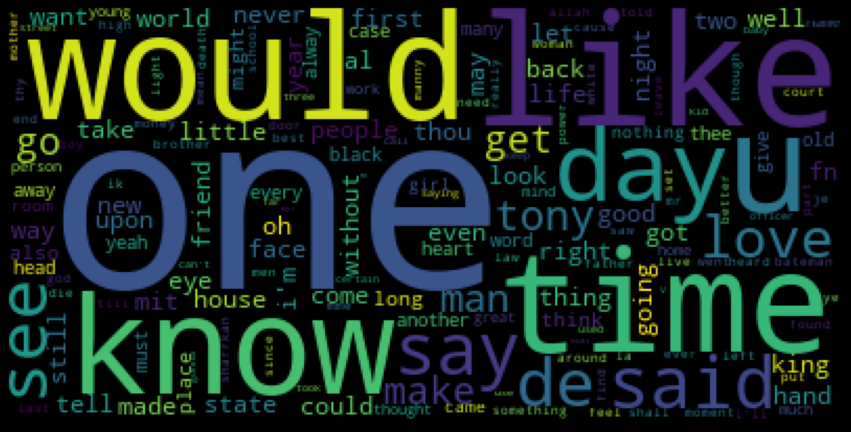

In [110]:
wordcloud = WordCloud(stopwords=stopwords_ls, collocations=False)
wordcloud.generate(','.join(removed_tokens_not100))

plt.figure(figsize = (15,15), facecolor = 'black')
plt.imshow(wordcloud)
plt.axis('off')

## Building our Top 100 WordCloud

In [111]:
corpus_100 = final_df[final_df['top_100']]['Lyrics'].to_list()

In [112]:
stopwords_ls = stopwords.words('english')
stopwords_ls[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [113]:
stopwords_ls.extend(string.punctuation)
stopwords_ls[-5:]

['`', '{', '|', '}', '~']

Now the normal, word_tokenize function doesn't know how to effectively read words from my experience. For example the word can't would be produced as "can" "'t". Which is not what we want, we want the full words. I found that the tweet tokenizer is able to handle this dataset more appropriately.

In [114]:
from nltk.tokenize import TweetTokenizer

In [115]:
tknzr = TweetTokenizer()

In [116]:
token = tknzr.tokenize('.'.join(corpus_100))

In [117]:
removed_tokens_top100 = [w.lower() for w in token if w.lower() not in stopwords_ls]
removed_tokens_top100[:25]

['ones',
 'make',
 'back',
 'home',
 'tour',
 'middle',
 'june',
 'planning',
 'welcome',
 'home',
 'barbecue',
 'green',
 'bean',
 'casserole',
 "grandma's",
 'recipe',
 'knock',
 'door',
 'around',
 'two',
 "o'clock",
 'two',
 'uniforms',
 'heart',
 'stopped']

In [118]:
freq = FreqDist(removed_tokens_top100)
freq.most_common(50)

[("i'm", 16913),
 ('like', 11639),
 ('know', 9950),
 ('yeah', 9898),
 ('love', 8768),
 ('oh', 8441),
 ('got', 7925),
 ('get', 7457),
 ('baby', 6173),
 ('go', 5836),
 ('cause', 5068),
 ("ain't", 5038),
 ('wanna', 4803),
 ('one', 4730),
 ("can't", 4611),
 ('back', 4433),
 ('time', 4397),
 ('never', 4390),
 ('see', 4318),
 ('want', 4289),
 ('say', 4288),
 ('girl', 4282),
 ('make', 4223),
 ('let', 4107),
 ('way', 3920),
 ('take', 3810),
 ('right', 3798),
 ('come', 3442),
 ("i'll", 3361),
 ('need', 3174),
 ('gonna', 3173),
 ("that's", 3094),
 ('feel', 3017),
 ('tell', 2843),
 ('could', 2689),
 ('night', 2675),
 ('hey', 2620),
 ('little', 2597),
 ('life', 2574),
 ('think', 2533),
 ('man', 2517),
 ('good', 2504),
 ('keep', 2338),
 ("i've", 2314),
 ('said', 2232),
 ('give', 2205),
 ('heart', 2174),
 ('every', 2153),
 ('look', 2036),
 ('la', 2024)]

Next we're going to visualize the most common lyrics in a wordcloud from our top 100 lyrics, which will show us how frequently a word appears based on how large it is. E.g. the bigger the word the more frequently it pops up.

(-0.5, 399.5, 199.5, -0.5)

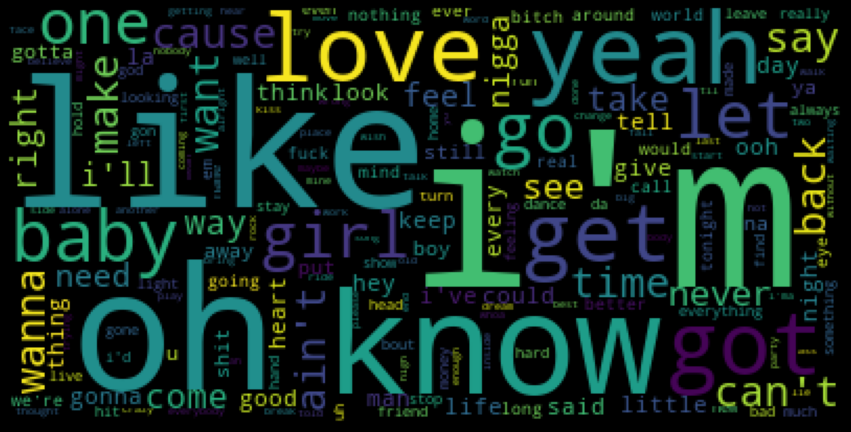

In [119]:
wordcloud = WordCloud(stopwords=stopwords_ls, collocations=False)
wordcloud.generate(','.join(removed_tokens_top100))

plt.figure(figsize = (15,15), facecolor = 'black')
plt.imshow(wordcloud)
plt.axis('off')

## Bigram

Next I want to see the most common word duos in lyrics. I'll do this with a bigram.

In [120]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
lyric = nltk.BigramCollocationFinder.from_words(removed_tokens_not100)
lyric_freq_not100 = lyric.score_ngrams(bigram_measures.raw_freq)

In [121]:
pd.DataFrame(lyric_freq_not100, columns=["Lyric","Freq"]).head(20)

,Lyric,Freq
0,"(zau, al-makan)",0.000510
1,"(mme, de)",0.000473
2,"(de, guermantes)",0.000403
3,"(aaron, swartz)",0.000348
4,"(de, charlus)",0.000322
5,"(united, states)",0.000306
6,"(oh, oh)",0.000219
7,"(high, school)",0.000212
8,"(yeah, yeah)",0.000205
9,"(wazir, dandan)",0.000204


In [122]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
lyric = nltk.BigramCollocationFinder.from_words(removed_tokens_top100)
lyric_freq_top100 = lyric.score_ngrams(bigram_measures.raw_freq)

In [123]:
pd.DataFrame(lyric_freq_top100, columns=["Lyric","Freq"]).head(20)

,Lyric,Freq
0,"(oh, oh)",0.003457
1,"(yeah, yeah)",0.002740
2,"(la, la)",0.001824
3,"(na, na)",0.001404
4,"(i'm, gonna)",0.001125
5,"(love, love)",0.001045
6,"(let, go)",0.001010
7,"(hey, hey)",0.000905
8,"(know, i'm)",0.000801
9,"(cause, i'm)",0.000786


## Exploring genre

Next I want to view some of my data when comparing genres to weekly ranks, peak positions and weeks on chart. I'm going to be combining both a bar plot and a swarm plot.

In [124]:
# sns.catplot(x="Top Genre_", y="Weekly.rank", kind="bar",
#             estimator=np.median,data=final_df,
#             height=10,aspect=11/10,hue='top_100')

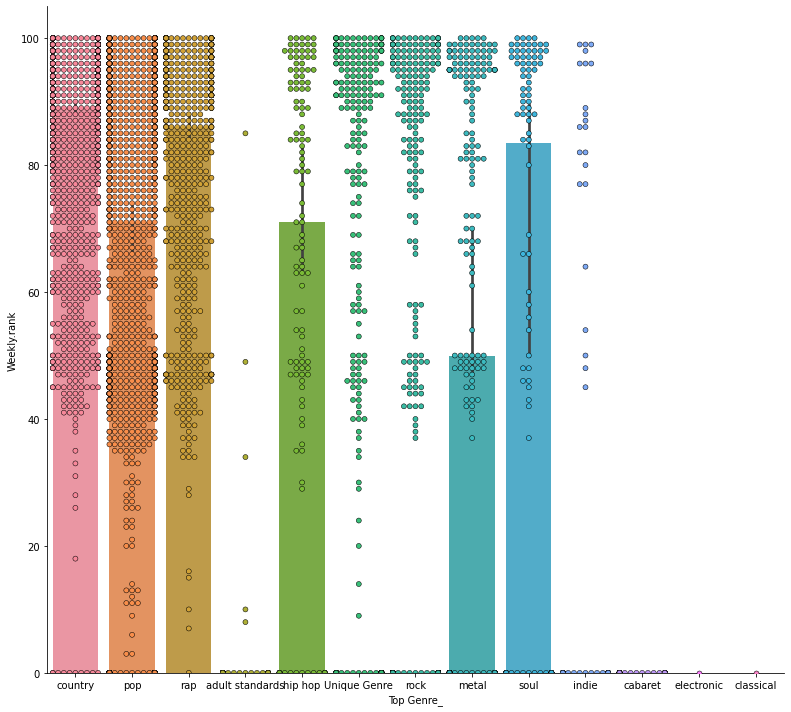

In [125]:
from numpy import median

sns.catplot(x="Top Genre_", y="Weekly.rank", kind="bar",
            estimator=np.median,data=final_df,
            height=10,aspect=11/10)
sns.swarmplot(x="Top Genre_", y="Weekly.rank", data=final_df,edgecolor='black',
              linewidth=0.5)
plt.show();

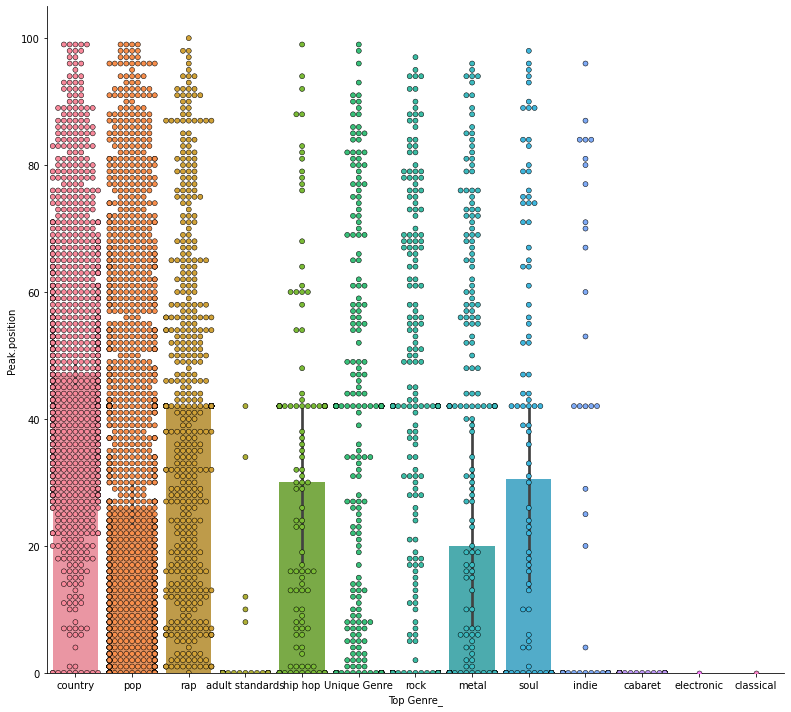

In [126]:
sns.catplot(x="Top Genre_", y="Peak.position", kind="bar",
            estimator=np.median,data=final_df,
            height=10,aspect=11/10)
sns.swarmplot(x="Top Genre_", y="Peak.position", data=final_df,
              edgecolor='black',
              linewidth=0.5)
plt.show();

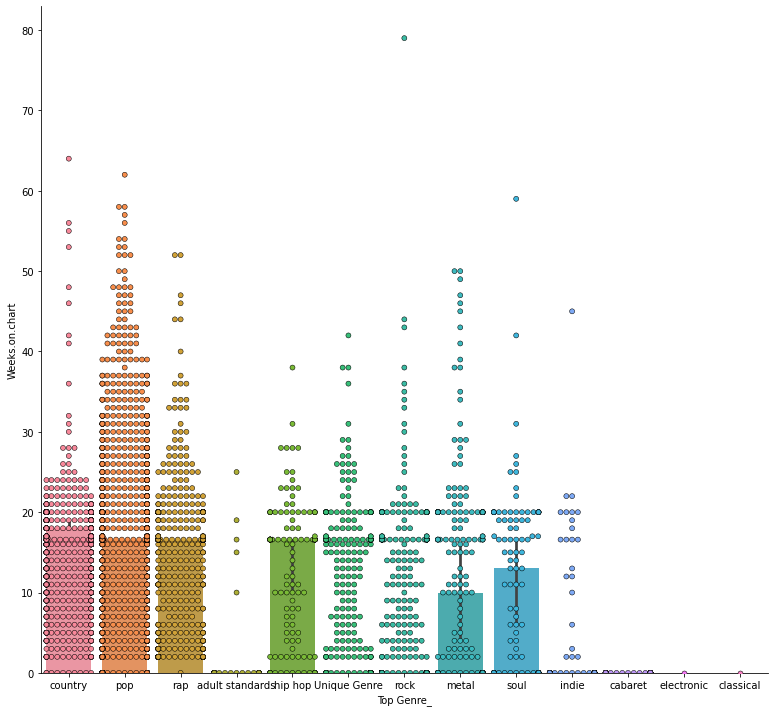

In [127]:
sns.catplot(x="Top Genre_", y="Weeks.on.chart", kind="bar",
            estimator=np.median,data=final_df,
            height=10,aspect=11/10)
sns.swarmplot(x="Top Genre_", y="Weeks.on.chart", data=final_df,
             edgecolor='black',linewidth=0.5)
plt.show();

I was surprised to find out that country was always sitting in the number one seat. But my opinion may be biased. Following Country we found that Pop, Rap and Hip-Hop play a strong role in being in the top 100 as well.

# Train Test Split

In [128]:
# final_df.sort_values(['Artist','Title','df'],inplace=True)

In [129]:
# final_df[final_df.duplicated(keep=False,
#                              subset=('Artist','Title'))]

## look in to dropping duplicates here
# .sort_values('Title')

In [130]:
# df_bb[df_bb['Lyrics'].duplicated(keep=False)].sort_values('Lyrics')

In [131]:
## Exploring how many made it
final_df['top_100'].value_counts(1)

True     0.687687
False    0.312313
Name: top_100, dtype: float64

In [132]:
from sklearn.preprocessing import LabelEncoder

Label encoding below in order to prep our data for the target.

In [133]:
le = LabelEncoder()
final_df['top.100'] = le.fit_transform(final_df['top_100'])
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5677 entries, 0 to 1993
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Artist             5677 non-null   object 
 1   Title              5677 non-null   object 
 2   Top Genre          5677 non-null   object 
 3   Popularity         5677 non-null   float64
 4   Danceability       5677 non-null   float64
 5   Energy             5677 non-null   float64
 6   Loudness (dB)      5677 non-null   float64
 7   Speechiness        5677 non-null   float64
 8   Acousticness       5677 non-null   float64
 9   Liveness           5677 non-null   float64
 10  Valence            5677 non-null   float64
 11  Length (Duration)  5677 non-null   object 
 12  Weekly.rank        5677 non-null   float64
 13  Peak.position      5677 non-null   float64
 14  Weeks.on.chart     5677 non-null   float64
 15  Lyrics             5677 non-null   object 
 16  top_100            5677 

In [134]:
y = final_df['top.100']
X = final_df['Lyrics']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=10)

In [136]:
y_train.value_counts(1)

1    0.687642
0    0.312358
Name: top.100, dtype: float64

Leveraging tweet tokenizer again so it can capture the full word as stated earlier in the notebook.

In [137]:
tokenizer = nltk.TweetTokenizer(preserve_case=False)
tokenizer

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer


## Initialize TfIdf Vectorizer, feed in function of tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_ls)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<3973x81688 sparse matrix of type '<class 'numpy.float64'>'
	with 801923 stored elements in Compressed Sparse Row format>

In [139]:
# from imblearn.over_sampling import RandomOverSampler 

In [140]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_tfidf, y_train)

# Random Forest

In [141]:
# fitting
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(class_weight='balanced')

In [142]:
y_hat_test = rf.predict(X_test_tfidf)

In [143]:
y_test_arr = y_test.to_numpy()

The below two functions will allow us to visualize our models using a confusion matrix as well show us the precision, accuracy, recall and f1-score.

In [144]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.grid(False)
    plt.show()

In [145]:
## Evaluate and view my model.

from sklearn.metrics import multilabel_confusion_matrix

def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=None,
                   verbose=False,scorer=False,
                   classes=['Not Top 100','Top 100'],
                  normalize = 'true'):
    
    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    if scoring is None:
        scoring = metrics.recall_score(y_test,y_hat_test,average='macro')
    
    cm = metrics.confusion_matrix(y_test, y_hat_test,
    normalize = normalize)
    plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")


    if verbose:
        print("MODEL PARAMETERS:")

        print(pd.Series(rf.get_params()))
## Use scoring = recall_macro in gridsearch.        
    if scorer:
        
        return recall_macro(y_test,y_hat_test)

Now we're running our Random Forest model

              precision    recall  f1-score   support

 Not Top 100       0.91      0.47      0.62       532
     Top 100       0.80      0.98      0.88      1172

    accuracy                           0.82      1704
   macro avg       0.86      0.73      0.75      1704
weighted avg       0.84      0.82      0.80      1704



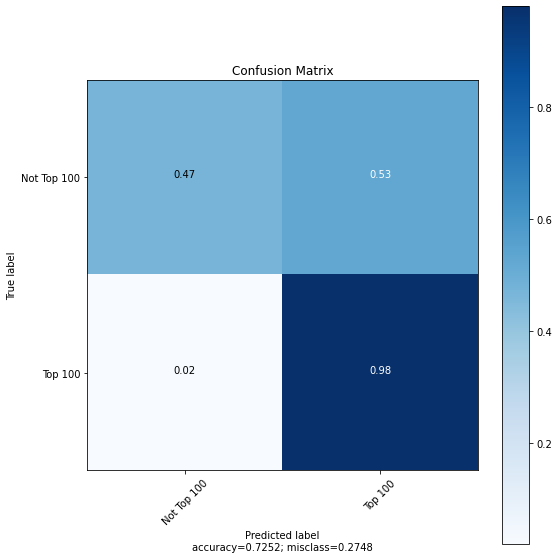

In [146]:
evaluate_model(y_test_arr,y_hat_test,X_test_tfidf,rf)

<AxesSubplot:>

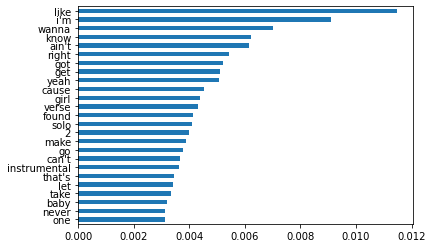

In [147]:
## Grabbing most import lyrics
pd.Series(rf.feature_importances_,
          index=vectorizer.get_feature_names()).sort_values().tail(25).plot(kind='barh')

# XGB

Next we're running our XGB model

In [148]:
## Fitting
xgb_rf = XGBClassifier()
xgb_rf.fit(X_train_tfidf, y_train)

XGBClassifier()

              precision    recall  f1-score   support

 Not Top 100       0.90      0.64      0.75       532
     Top 100       0.85      0.97      0.91      1172

    accuracy                           0.86      1704
   macro avg       0.88      0.80      0.83      1704
weighted avg       0.87      0.86      0.86      1704



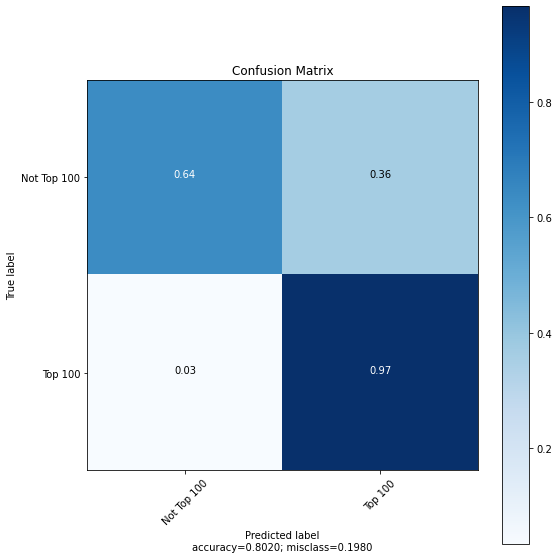

In [149]:
y_pred2 = xgb_rf.predict(X_test_tfidf)

evaluate_model(y_test_arr,y_pred2,X_test,xgb_rf)

<AxesSubplot:>

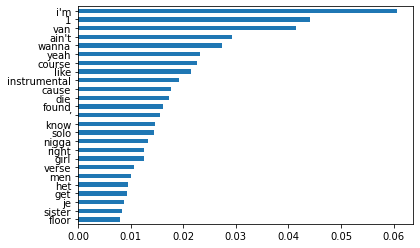

In [150]:
## Grabbing most import lyrics
pd.Series(xgb_rf.feature_importances_,
          index=vectorizer.get_feature_names()).sort_values().tail(25).plot(kind='barh')

# SVM

Finally we're running our SVM model

              precision    recall  f1-score   support

 Not Top 100       0.76      0.73      0.75       532
     Top 100       0.88      0.89      0.89      1172

    accuracy                           0.84      1704
   macro avg       0.82      0.81      0.82      1704
weighted avg       0.84      0.84      0.84      1704



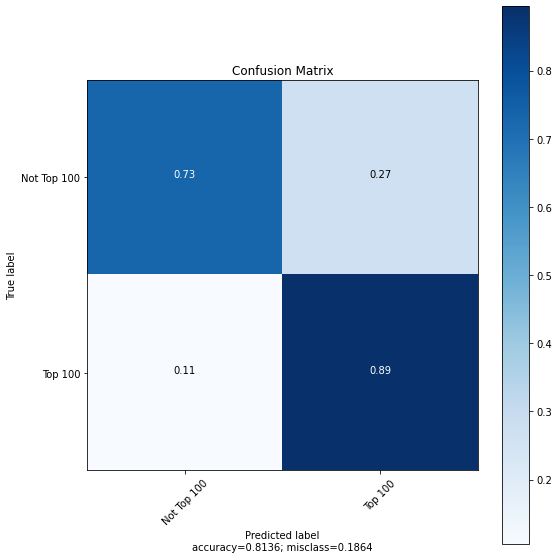

In [151]:
from sklearn.svm import SVC

clf = SVC(kernel='linear',class_weight='balanced')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_test_tfidf)

evaluate_model(y_test_arr,y_pred,X_test_tfidf,clf)

Next I want to see our most important words, we'll do this by pulling them out from the coefficient which in turn, are our words. This will help us understand how important each word is.

In [152]:
coef = clf.coef_.todense()
coef.shape
words = pd.DataFrame(coef, columns=vectorizer.get_feature_names()).T
words
## Make the absolut value in another column.

,0
#0023212,0.000000
#1-217,0.000000
#10063,0.000000
#10125,0.000000
#11,0.000000
...,...
（,0.006525
）,0.006525
２人,0.001631
￼,-0.299033


In [153]:
words.sort_values(by=0,axis=0, ascending=True)

,0
verse,-3.944790
instrumental,-3.530327
’,-3.259087
pre-chorus,-2.933716
solo,-2.747113
...,...
wanna,1.789969
bout,1.802342
front,1.818364
might,2.068768


In [154]:
## SVM Gridsearch
parameters = {'C': [1, 10], 
          'gamma': [0.001, 0.01, 1,'auto'],
             'class_weight':['balanced','None']}
model = SVC()
grid = GridSearchCV(estimator=model, param_grid=parameters)
# clf = SVC(kernel='linear',class_weight='balanced')
# clf.fit(X_train_tfidf,y_train)
# y_pred = clf.predict(X_test_tfidf)

In [155]:
grid.fit(X_train_tfidf,y_train)
print(grid)
# summarization of results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'class_weight': ['balanced', 'None'],
                         'gamma': [0.001, 0.01, 1, 'auto']})
0.8240631782393105
SVC(C=1, class_weight='balanced', gamma=1)


              precision    recall  f1-score   support

 Not Top 100       0.76      0.73      0.75       532
     Top 100       0.88      0.89      0.89      1172

    accuracy                           0.84      1704
   macro avg       0.82      0.81      0.82      1704
weighted avg       0.84      0.84      0.84      1704



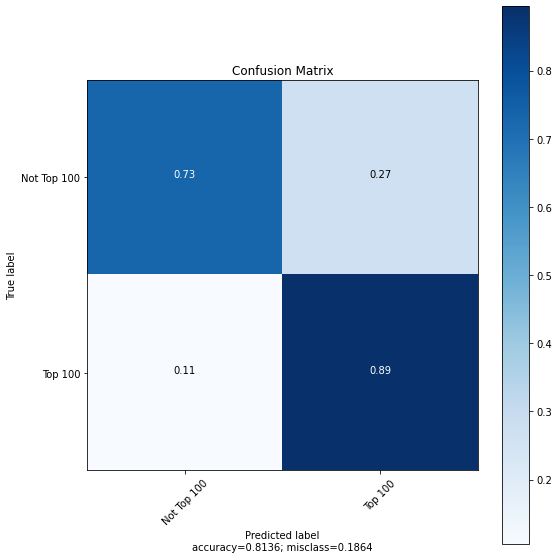

In [156]:
evaluate_model(y_test_arr,y_pred,X_test_tfidf,model)

# Conclusion

In conclusion the model that performed most strongly was our XGB model. We found that there are certain lyrics that appeared most frequently as well as had the most impact when it came to these lyrics being in the top 100. Some of the most important lyrics found were:
- Van
- Die
- Age
- Running

There were also plenty of lyrics that would be considered by most as 'common' which in fairness they are. I believe this speaks to the simplicity of the music industry, lyrically at least.

Another thing to take note on is how genre plays a role in regards to being in the top 100. The three most successful categories were Country, Pop and Hip Hop / Rap. My suggestion to anyone looking to make headway in music would be to leverage the important words we found and make sure it's in one of the 3 or a combination of the 2 genres stated previously.
